# Digit Recognition using PyTorch

In this competition, our goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms.

### Importing Libraries

In [19]:
#Importing all libraries
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torch.autograd import Variable

import time
import helper
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

### Importing Dataset

In [20]:
#Import data
train_df = pd.read_csv('../input/digit-recognizer/train.csv')
test_df = pd.read_csv('../input/digit-recognizer/test.csv')

## Train and Validation datasets
Splitting dataset into train and validation. Also converting them to float values.

In [21]:
#Labels(Targets) and Inputs
train_labels = train_df['label'].values
train_images = (train_df.iloc[:,1:].values).astype('float32')
test_images = (test_df.iloc[:,:].values).astype('float32')

#Training and Validation Split
train_images, val_images, train_labels, val_labels = train_test_split(train_images, 
                                                                      train_labels,
                                                                     stratify=train_labels, 
                                                                      random_state=302,
                                                                     test_size=0.2)

## Reshaping the data to make Tensors

In [22]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)
#val
val_images_tensor = torch.tensor(val_images)/255.0
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)
#test
test_images_tensor = torch.tensor(test_images)/255.0

In [23]:
#View Tensor shapes 
train_images_tensor.shape, train_labels_tensor.shape 

(torch.Size([33600, 784]), torch.Size([33600]))

## Viewing the Images

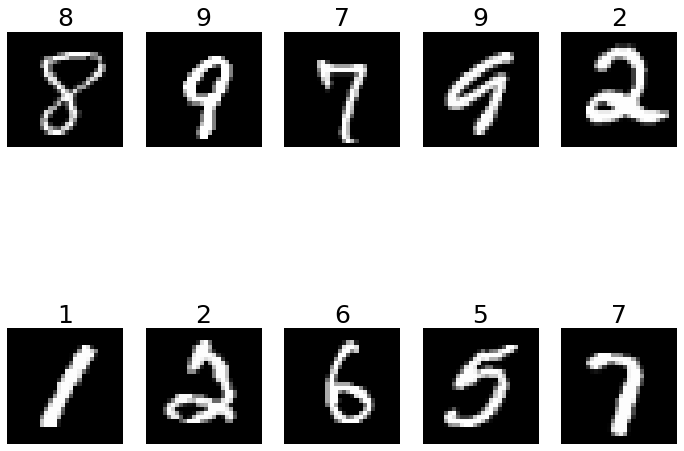

In [24]:
fig, axes = plt.subplots(2,5, figsize=(12,10))
axes = axes.flatten()
idx = np.random.randint(0,5000,size=10)
for i in range(10):
    axes[i].imshow(train_images[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(train_labels[idx[i]])), color= 'black', fontsize=25)
plt.show()

## Feeding tensors to data loader

In [25]:
#Dataloader
train_loader = DataLoader(train_tensor, batch_size = 64, num_workers=2, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size = 64, num_workers=2, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size = 32, num_workers=2, shuffle=False)

In [26]:
len(train_loader)

525

## Defining Model Architecture

In [27]:
model = nn.Sequential(nn.Linear(784, 512),
                      nn.LeakyReLU(),
                      nn.Linear(512, 512),
                      nn.BatchNorm1d(512),
                      nn.LeakyReLU(),
                      nn.Linear(512, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=2.0e-4 , momentum = 0.9)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
device

device(type='cuda')

In [28]:
model.to(device)
model

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Linear(in_features=512, out_features=10, bias=True)
  (6): LogSoftmax()
)

In [29]:
def count_parameters(model):
    """
    Counts the number of trainable parameters
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [30]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 670,730 trainable parameters


### Functions for training and evaluation

In [31]:
def calculate_accuracy(y_pred, y):
    """
    Calculates the accuracy of training/evaluating
    """
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [32]:
def train(model, iterator, optimizer, criterion, device):  
    """
    Training function 
    Input : Model, Iterator = train data loader, Optimizer function,
            Criterian, device = cuda or cpu 
    Output: Training Loss and Training Accuracy
    """
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for (x, y) in iterator:
        x = x.float().to(device)
        y = y.type(torch.LongTensor).to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [33]:
def evaluate(model, iterator, criterion, device):  
    """
    Evaluation Function
    Input : Model, iterator = test data loader, criterian of loss,
            device = cuda or cpu
    Output: Test loss, test accuracy
    """
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.float().to(device)
            y = y.type(torch.LongTensor).to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)



In [34]:
def epoch_time(start_time, end_time):
    """
    Function to calculate total time taken in an epoch
    """
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Training the model over train dataset

In [ ]:
EPOCHS = 50
best_valid_loss = float('inf')
train_l, valid_l, train_a, valid_a = [], [], [], [] 


for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    train_l.append(train_loss)
    valid_l.append(valid_loss)

    train_a.append(train_acc)
    valid_a.append(valid_acc)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 0.436 | Train Acc: 89.08%
	 Val. Loss: 0.236 |  Val. Acc: 93.31%
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 0.196 | Train Acc: 94.74%
	 Val. Loss: 0.171 |  Val. Acc: 95.17%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 0.138 | Train Acc: 96.25%
	 Val. Loss: 0.134 |  Val. Acc: 96.21%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.105 | Train Acc: 97.22%
	 Val. Loss: 0.121 |  Val. Acc: 96.39%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.082 | Train Acc: 97.86%
	 Val. Loss: 0.110 |  Val. Acc: 96.65%
Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 0.065 | Train Acc: 98.37%
	 Val. Loss: 0.103 |  Val. Acc: 96.91%
Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 0.053 | Train Acc: 98.79%
	 Val. Loss: 0.097 |  Val. Acc: 97.08%
Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 0.042 | Train Acc: 99.08%
	 Val. Loss: 0.092 |  Val. Acc: 97.22%
Epoch: 09 | Epoch Time: 0m 2s
	Train Loss: 0.035 | Train Acc: 99.36%
	 Val. Loss: 0.090 |  Val. Acc: 97.40%
Epoch: 10 | Epoch Time: 0m 2

In [ ]:
plt.plot(train_l, label='Training loss')
plt.plot(valid_l, label='Validation loss')
plt.legend(frameon=False)

## Loading the saved model

In [ ]:
model.load_state_dict(torch.load('model.pt'))

## Viewing the trained data images

In [ ]:

def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [ ]:
images, labels = next(iter(train_loader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
view_classify(img.view(1, 28, 28), ps)

## Prediction

In [ ]:
def make_predictions(data_loader):
    model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)
        data = data.view(data.size(0), -1)
        output = model(data)
        
        preds = output.data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

In [ ]:
test_set_preds = make_predictions(test_loader)
test_new = TensorDataset(test_images_tensor, test_set_preds)
testnew = DataLoader(test_new, batch_size=16, num_workers=2, shuffle=False)

In [ ]:
images, labels = next(iter(testnew))

idx = np.random.randint(0,16)
img = images[idx].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
view_classify(img.view(1, 28, 28), ps)

## Submission

In [ ]:
sub = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
sub['Label'] = test_set_preds.numpy().squeeze()
sub.to_csv("MLP#1.csv", index=False)
sub.head()